In [1]:
import pandas as pd
from abc import ABC, abstractmethod
import nbimporter
from ta_indicator import get_indicator_data
import numpy as np
import matplotlib.pyplot as plt

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\nbformat\__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [2]:
class ISignalGeneration(ABC):
    @abstractmethod
    def strategic(self, indicator_data):
        pass

In [3]:
class RSISignal(ISignalGeneration):
    def strategic(self, indicator_data):

        indicator_data["rsi_trade_signal"] = 0
        
        # Overbought → Sell Signal
        indicator_data.loc[indicator_data["rsi"] >= 70, "rsi_trade_signal"] = 1

        # Oversold → Buy Signal
        indicator_data.loc[indicator_data["rsi"] <= 30, "rsi_trade_signal"] = -1
        
        indicator_data["rsi_trade_signal"] = indicator_data["rsi_trade_signal"].astype(int)

        return indicator_data

In [4]:
class MomemtumSignal(ISignalGeneration):
    def strategic(self, indicator_data):

        short_ma = indicator_data["short_ma"]
        long_ma = indicator_data["long_ma"]

        # Avoid division by zero or invalid ops
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = (short_ma / long_ma - 1) * 1000
            ratio = ratio.replace([np.inf, -np.inf], np.nan)  

        # Initialize sentiment as NaN
        sentiment = pd.Series(np.nan, index=indicator_data.index)

        # Valid rows where both MAs are not NaN
        valid_mask = short_ma.notna() & long_ma.notna()

        # Compute sentiment only for valid rows
        sentiment[valid_mask] = np.where(
            short_ma[valid_mask] > long_ma[valid_mask],
            np.minimum(100, ratio[valid_mask]).astype(int),
            np.maximum(1, ratio[valid_mask]).astype(int)
        )
        
        # Initialize all signals to 0
        indicator_data["momentum_trade_signal"] = 0

        # Set signals only where sentiment is valid (not NaN)
        indicator_data.loc[sentiment >= 60, "momentum_trade_signal"] = 1
        indicator_data.loc[sentiment <= 40, "momentum_trade_signal"] = -1

        indicator_data["momentum_trade_signal"] = indicator_data["momentum_trade_signal"].astype(int)

        return indicator_data


In [5]:
class StochasticOscillatorSignal(ISignalGeneration):
    def strategic(self, indicator_data):
        k = indicator_data["sto_k"]
        d = indicator_data["sto_d"]

        # Compute raw sentiment
        sentiment = 50 + (k - d) * 25

        # Set sentiment to NaN where k or d is NaN
        sentiment[(k.isna()) | (d.isna())] = np.nan

        # Clamp between 1 and 100
        sentiment = sentiment.clip(lower=1, upper=100)

        # Default signal to 0 (integer)
        indicator_data["sto_trade_signal"] = 0

        # Set signals only where sentiment is not NaN
        indicator_data.loc[sentiment >= 60, "sto_trade_signal"] = 1
        indicator_data.loc[sentiment <= 40, "sto_trade_signal"] = -1

        # Ensure it's int type — safe here because no NaNs remain
        indicator_data["sto_trade_signal"] = indicator_data["sto_trade_signal"].astype(int)

        return indicator_data


In [6]:
class BollingerBandsStrategy(ISignalGeneration):
    def strategic(self, indicator_data):
        indicator_data["bb_trade_signal"] = 0

        indicator_data.loc[indicator_data["close"] <= indicator_data["Lower_1"], "bb_trade_signal"] = 1
        indicator_data.loc[indicator_data["close"] >= indicator_data["Upper_1"], "bb_trade_signal"] = -1

        indicator_data["bb_trade_signal"] = indicator_data["bb_trade_signal"].astype(int)

        return indicator_data
            

In [7]:
class MACDStrategic(ISignalGeneration):
    def strategic(self, indicator_data):
        
        macd_current = indicator_data["macd"]
        macd_prev = indicator_data["macd"].shift(1)

        macd_signal_current = indicator_data["macd_signal"]
        macd_signal_prev = indicator_data["macd_signal"].shift(1)

        # Initialize signal column
        indicator_data["macd_trade_signal"] = 0

        # Buy signal: MACD crosses above the signal line
        buy_condition = (macd_prev <= macd_signal_prev) & (macd_current > macd_signal_current)
        indicator_data.loc[buy_condition, "macd_trade_signal"] = 1

        # Sell signal: MACD crosses below the signal line
        sell_condition = (macd_prev >= macd_signal_prev) & (macd_current < macd_signal_current)
        indicator_data.loc[sell_condition, "macd_trade_signal"] = -1

        return indicator_data


In [8]:
class CombStrategic(ISignalGeneration):
    def strategic(self, indicator_data):

        indicator_data["final_trade_signal"] = 0

        # BUY signal: when both RSI and MACD suggest a buy
        indicator_data.loc[
            (indicator_data["rsi_trade_signal"] == 1) & (indicator_data["macd_trade_signal"] == 1),
            "final_trade_signal"
        ] = 1

        # SELL signal: when both RSI and MACD suggest a sell
        indicator_data.loc[
            (indicator_data["rsi_trade_signal"] == -1) & (indicator_data["macd_trade_signal"] == -1),
            "final_trade_signal"
        ] = -1

        return indicator_data


In [9]:
def get_signal_generation():
    data = get_indicator_data()
    data = RSISignal().strategic(data)
    data = MomemtumSignal().strategic(data)
    data = StochasticOscillatorSignal().strategic(data)
    data = BollingerBandsStrategy().strategic(data)
    data = MACDStrategic().strategic(data)
    data = CombStrategic().strategic(data)

    return data

In [10]:
indicator_data = get_signal_generation()
indicator_data.to_csv("indicator.csv", index=True)

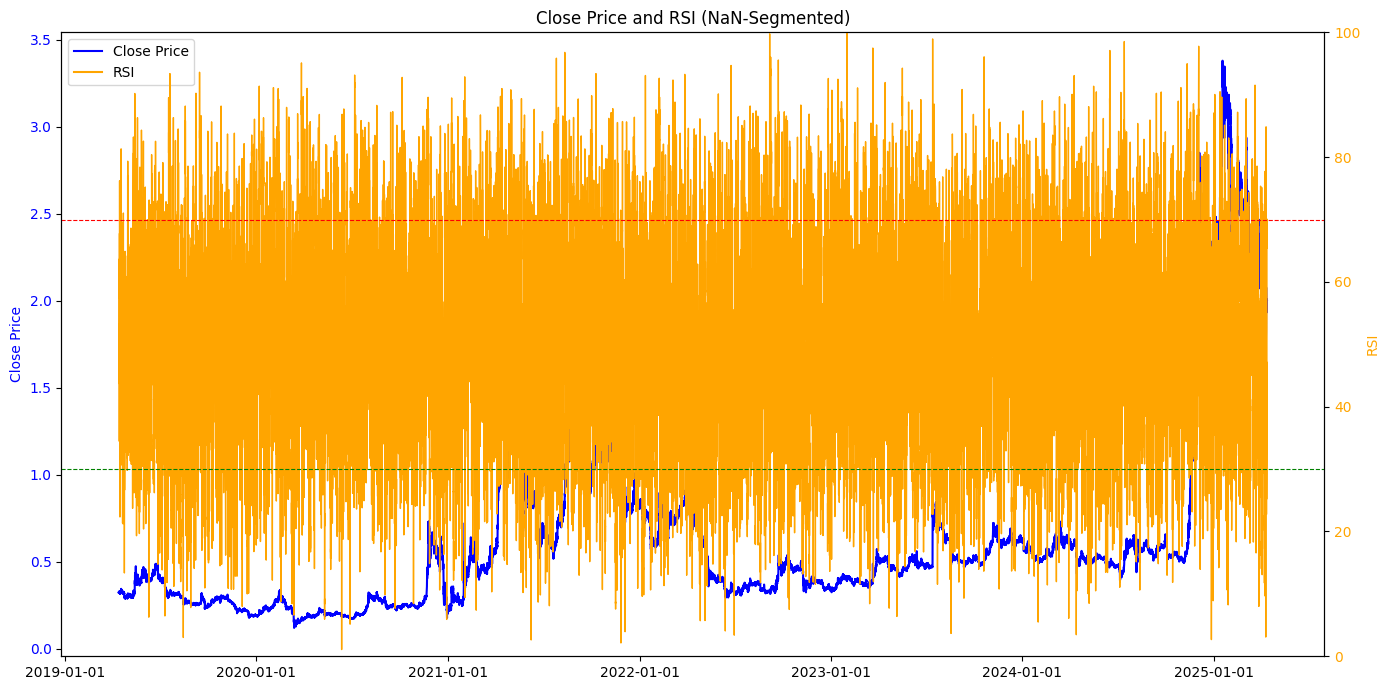

In [ ]:
indicator_data = get_signal_generation()

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_title("Close Price and RSI Indicator")
ax1.set_xlabel("Date")

# Plot Close price
ax1.plot(indicator_data.index, indicator_data["close"], color="blue", label="Close Price")
ax1.set_ylabel("Close Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for RSI
ax2 = ax1.twinx()
ax2.plot(indicator_data.index, indicator_data["rsi"], color="orange", label="RSI")
ax2.set_ylabel("RSI", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")
ax2.axhline(70, color="red", linestyle="--", linewidth=1)
ax2.axhline(30, color="green", linestyle="--", linewidth=1)

fig.tight_layout()
plt.legend(loc="upper left")
plt.show()


In [12]:
signal_generation = get_signal_generation()
print(signal_generation.head(100))

trade_counts = signal_generation["final_trade_signal"].value_counts()
print(f"Count of 1 (buy signal): {trade_counts.get(1, 0)}")
print(f"Count of -1 (sell signal): {trade_counts.get(-1, 0)}")
freq = ((signal_generation["final_trade_signal"] == 1) | (signal_generation["final_trade_signal"] == -1)).sum() / len(signal_generation)
print(f"frequency: {freq}")


                        close      high       low      open        volume  \
datetime                                                                    
2019-04-13 11:00:00  0.324656  0.325658  0.321414  0.321631  5.438059e+06   
2019-04-13 12:00:00  0.323879  0.327485  0.322847  0.325811  2.254610e+06   
2019-04-13 13:00:00  0.324818  0.327435  0.323023  0.324852  1.373858e+06   
2019-04-13 14:00:00  0.326190  0.327597  0.324320  0.324870  2.731291e+06   
2019-04-13 15:00:00  0.324661  0.327893  0.324107  0.326253  3.749263e+06   
...                       ...       ...       ...       ...           ...   
2019-04-17 10:00:00  0.321247  0.323252  0.319770  0.320425  1.958476e+06   
2019-04-17 11:00:00  0.322623  0.325637  0.320957  0.320970  2.699700e+06   
2019-04-17 12:00:00  0.320027  0.323741  0.320291  0.322059  3.845899e+06   
2019-04-17 13:00:00  0.334323  0.335816  0.320180  0.322185  5.732275e+07   
2019-04-17 14:00:00  0.333401  0.335340  0.329096  0.335340  1.752826e+07   